# Multi-Channel CNN with 2 branches

In [1]:
import os
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point


# Directories
os.makedirs("plots", exist_ok=True)
os.makedirs("models", exist_ok=True)


## Data pre-processing

In [57]:
# 1. Load Raster Images
def load_raster_data(filepaths):
    rasters = []
    for filepath in filepaths:
        with rasterio.open(filepath) as src:
            rasters.append(src.read(1))  # Load the first band
    return np.stack(rasters, axis=-1), src.transform

# Function to generate file paths for n raster images
def generate_raster_paths(base_path, img_names):
    return [os.path.join(base_path, img_name) for img_name in img_names]

# -----------------------------------------------------------------------
# Set the names of the input images!!
# -----------------------------------------------------------------------

# List of raster image filenames
img_names = ["rainfall_raster_bound.tif", "clay_raster_bound.tif", "elevation_raster.tif"]  # Add more as needed
data_paths = generate_raster_paths(os.path.join("..", "CNN_from_R", "images_for_CNN"), img_names)
in_ims_stacked, transform = load_raster_data(data_paths)

# 2. Load the recharge rate data
clor = pd.read_csv("../Data/dat07_u.csv")
quant = "Recharge RC 50% mm/y" 

# Drop NaNs for essential columns
clor = clor.dropna(subset=["lat", "lon", quant])

# Convert clor to a GeoDataFrame
geometry = [Point(xy) for xy in zip(clor['lon'], clor['lat'])]
clor_gdf = gpd.GeoDataFrame(clor, geometry=geometry, crs="EPSG:3577")  # WGS84 (lat/lon)

# Extract the reprojected coordinates
clor_gdf['x'] = clor_gdf.geometry.x
clor_gdf['y'] = clor_gdf.geometry.y

# 3. Extract Sample-Centered Terrain Images
def extract_sample_centered_images(clor_gdf, in_ims_stacked, transform, size=32):
    rows, cols, num_layers = in_ims_stacked.shape
    half_size = size // 2
    terrain_images = []

    for _, row in clor_gdf.iterrows():
        x, y = row["x"], row["y"]
        col, row = ~transform * (x, y)
        col, row = int(col), int(row)
        
        if 0 <= row-half_size < rows and 0 <= col-half_size < cols:
            img = in_ims_stacked[row-half_size:row+half_size, col-half_size:col+half_size, :]
            if img.shape == (size, size, num_layers):
                terrain_images.append(img)
            else:
                terrain_images.append(np.zeros((size, size, num_layers)))  # Pad with zeros if out of bounds
        else:
            terrain_images.append(np.zeros((size, size, num_layers)))  # Completely out of bounds

    return np.array(terrain_images)

# Use the updated coordinates
imgs_ann = extract_sample_centered_images(clor_gdf, in_ims_stacked, transform)

C:\Users\nefel\AppData\Local\Temp\ipykernel_17452\1872343158.py:19: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  clor = pd.read_csv("../Data/dat07_u.csv")


In [59]:
for path in data_paths:
    with rasterio.open(path) as src:
        transform = src.transform
        pixel_width = transform[0]   # `a` value: pixel size in x-direction
        pixel_height = -transform[4] # `e` value (negated because it's typically negative)
        print(f"File: {path} - Pixel size: {pixel_width} x {pixel_height}")

File: ..\CNN_from_R\images_for_CNN\rainfall_raster_bound.tif - Pixel size: 0.05 x 0.05
File: ..\CNN_from_R\images_for_CNN\clay_raster_bound.tif - Pixel size: 0.05 x 0.05
File: ..\CNN_from_R\images_for_CNN\elevation_raster.tif - Pixel size: 0.05 x 0.05


#### Checking the centered images

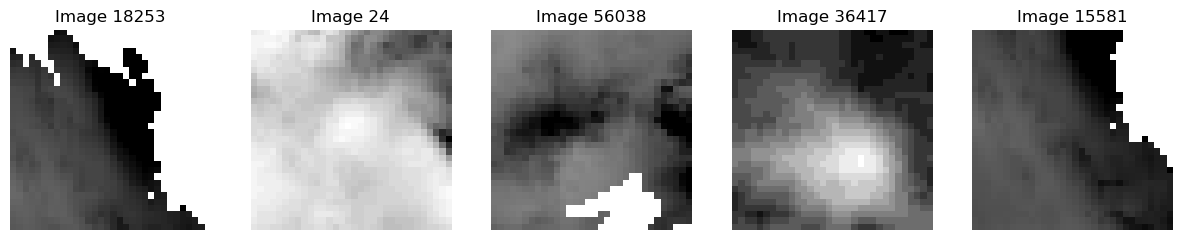

In [67]:
n = 5

# Select random images or specific indices
indices = np.random.choice(imgs_ann.shape[0], n, replace=False)

# Plot the images
fig, axs = plt.subplots(1, n, figsize=(15, 5))
for i, idx in enumerate(indices):
    axs[i].imshow(imgs_ann[idx,:,:,0], cmap="binary")
    axs[i].set_title(f"Image {idx}")
    axs[i].axis("off")
plt.show()

### Creating the location input

In [4]:
# -----------------------------------------------------------------------
# Select the same features in loc as the images selected in the cell above
# -----------------------------------------------------------------------
recharge_data = clor[['lat','lon','Rain mm/y', 'Recharge RC 50% mm/y', 'rainfall_seasonality', 'PET mm/y', 'elevation_mahd', 'distance_to_coast_km', 'ndvi_avg', 'clay_perc', 'soil_class']]
loc = recharge_data[['lat','lon','Rain mm/y', 'rainfall_seasonality', 'PET mm/y', 'elevation_mahd', 'distance_to_coast_km', 'ndvi_avg', 'clay_perc', 'soil_class']]

### Split data in train, val and test

In [68]:
# Split the data in 10 folds
np.random.seed(321)
fold_size = recharge_data.shape[0] // 10

# Shuffles the indices of the dataset
indices = np.arange(recharge_data.shape[0])
np.random.shuffle(indices)

# Split indices into test, validation, and train sets
test = indices[:fold_size]
val = indices[fold_size:2*fold_size]
train = indices[2*fold_size:]

x_train_imgs, x_train_loc = imgs_ann[train], loc.iloc[train].to_numpy()
x_val_imgs, x_val_loc = imgs_ann[val], loc.iloc[val].to_numpy()
x_test_imgs, x_test_loc = imgs_ann[test], loc.iloc[test].to_numpy()

#Why are we doing this???
#x_train[0] = x_train[0].reshape((x_train[0].shape[0], 32, 32, 1))
#x_val[0] = x_val[0].reshape((x_val[0].shape[0], 32, 32, 1))
#x_test[0] = x_test[0].reshape((x_test[0].shape[0], 32, 32, 1))

# Take the log of the recharge rate to make the distribution less skewed and set as target
y_train = np.log(recharge_data['Recharge RC 50% mm/y'].astype(float)[train])
y_val = np.log(recharge_data['Recharge RC 50% mm/y'].astype(float)[val])
y_test = np.log(recharge_data['Recharge RC 50% mm/y'].astype(float)[test])


### Normalize the data

In [69]:
class DataNormalizer:
    def __init__(self, train_data):
        # Calculate mean and standard deviation from training data
        self.mean = train_data.mean(axis=0)
        self.std = train_data.std(axis=0)

    def normalize(self, data):
        # Normalize data using the mean and std from the training data
        return (data - self.mean) / self.std

# Create a normalizer using the training data
normalizer = DataNormalizer(x_train_loc)

# Normalize the validation and test data using the same normalizer
x_train_loc_norm = normalizer.normalize(x_train_loc)
x_val_loc_norm = normalizer.normalize(x_val_loc)
x_test_loc_norm = normalizer.normalize(x_test_loc)


In [ ]:

# Calculate column means
#loc_mean = loc.mean()

# Calculate column standard deviations
#loc_sd = loc.std()

# Standardize the data (z-score normalization)
#loc_ann = ((loc - loc_mean) / loc_sd).to_numpy()

# Nef: I have worked until here, the rest is the older code. The code I replaced the above code with is at the very end

## Model Definition

In [71]:
# Use neural network to learn relationship between terrain features and geochemistry ####
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Activation, SpatialDropout2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import HeNormal, Zeros

ModuleNotFoundError: No module named 'tensorflow'

In [73]:
# We assume that the number of features is the same in both branches
input_features = 3

# Defining Model ----------------------------------------------------------
time = tf.timestamp()

dropratespat = 0.5  # match what model was trained with
dropratedense = 0.2  # match what model was trained with

kernel_ini = HeNormal()
bias_ini = Zeros()

# Convolutional stack:
conv_input = Input(shape=(32, 32, input_features), name='conv_input')

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=3, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_input)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = GlobalAveragePooling2D()(conv_output)
conv_output = Flatten()(conv_output)

# Auxiliary input:
auxiliary_input = Input(shape=(input_features+3,), name='aux_input')

auxiliary_output = Dense(1920, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(auxiliary_input)
auxiliary_output = Activation("relu")(auxiliary_output)
auxiliary_output = Dropout(rate=dropratedense)(auxiliary_output)
auxiliary_output = Flatten()(auxiliary_output)

# Main output:
main_output = Concatenate()([conv_output, auxiliary_output])
main_output = Dense(1024, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(256, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(units=2, activation="linear", name="dist_param", kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = tf.keras.layers.Lambda(lambda x: tfd.Normal(loc=x[:, 0:1], scale=1e-3 + tf.nn.softplus(0.1 * x[:, 1:2])))(main_output)

# Remove the model if it exists (not needed in Python as we can just overwrite)
model = tf.keras.Model(
    inputs=[conv_input, auxiliary_input], 
    outputs=main_output
)

# Print the summary of the model
model.summary()

# Define the negative log-likelihood function
def negloglik(y, model):
    return -model.log_prob(y)

# Define the optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)

# Compile the model
model.compile(
    loss=negloglik,
    optimizer=opt
)

NameError: name 'HeNormal' is not defined

## Modification of the original code to make it into a class

In [ ]:
# Use neural network to learn relationship between terrain features and geochemistry ####

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, SpatialDropout2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import HeNormal, Zeros
from tensorflow_probability import distributions as tfd

np.random.seed(321)
fold_size = gchem.shape[0] // 10
test = np.random.choice(gchem.shape[0], fold_size, replace=False)
val = np.random.choice(np.setdiff1d(np.arange(gchem.shape[0]), test), fold_size, replace=False)
train = np.setdiff1d(np.arange(gchem.shape[0]), np.concatenate((test, val)))

# Data Preparation --------------------------------------------------------

x_train = [imgs_ann[train, :, :], loc_ann[train, :]]
x_val = [imgs_ann[val, :, :], loc_ann[val, :]]
x_test = [imgs_ann[test, :, :], loc_ann[test, :]]

x_train[0] = x_train[0].reshape((x_train[0].shape[0], imagedim, imagedim, 1))
x_val[0] = x_val[0].reshape((x_val[0].shape[0], imagedim, imagedim, 1))
x_test[0] = x_test[0].reshape((x_test[0].shape[0], imagedim, imagedim, 1))

if logtrans:
    y_train = np.log(gchem[:, elem].astype(float))[train]
    y_val = np.log(gchem[:, elem].astype(float))[val]
    y_test = np.log(gchem[:, elem].astype(float))[test]
else:
    y_train = gchem[:, elem].astype(float)[train]
    y_val = gchem[:, elem].astype(float)[val]
    y_test = gchem[:, elem].astype(float)[test]

# Defining Model ----------------------------------------------------------
time = tf.timestamp()

dropratespat = 0.5  # match what model was trained with
dropratedense = 0.2  # match what model was trained with

kernel_ini = HeNormal()
bias_ini = Zeros()

# Convolutional stack:
conv_input = Input(shape=(imagedim, imagedim, 1), name='conv_input')

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=3, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_input)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = GlobalAveragePooling2D()(conv_output)
conv_output = Flatten()(conv_output)

# Auxiliary input:
auxiliary_input = Input(shape=(3,), name='aux_input')

auxiliary_output = Dense(1920, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(auxiliary_input)
auxiliary_output = Activation("relu")(auxiliary_output)
auxiliary_output = Dropout(rate=dropratedense)(auxiliary_output)
auxiliary_output = Flatten()(auxiliary_output)

# Main output:
main_output = Concatenate()([conv_output, auxiliary_output])
main_output = Dense(1024, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(256, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(units=2, activation="linear", name="dist_param", kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = tf.keras.layers.Lambda(lambda x: tfd.Normal(loc=x[:, 0:1], scale=1e-3 + tf.nn.softplus(0.1 * x[:, 1:2])))(main_output)

# Remove the model if it exists (not needed in Python as we can just overwrite)
model = tf.keras.Model(
    inputs=[conv_input, auxiliary_input], 
    outputs=main_output
)

# Print the summary of the model
model.summary()

# Define the negative log-likelihood function
def negloglik(y, model):
    return -model.log_prob(y)

# Define the optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)

# Compile the model
model.compile(
    loss=negloglik,
    optimizer=opt
)

## Training

In [40]:
# Define the model
model = models.Model(inputs=[conv_input, auxiliary_input], outputs=main_output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='mean_squared_error',  # Adjust loss function as needed
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ conv_input          │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 10, 10,    │      1,280 │ conv_input[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 10, 10,    │          0 │ conv2d_8[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_8 │ (None, 10, 10,    │          0 │ activation_14[0]… │
│ (SpatialDropout2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ spatial_dropout2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 8, 8, 128) │          0 │ conv2d_9[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_9 │ (None, 8, 8, 128) │          0 │ activation_15[0]… │
│ (SpatialDropout2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 6, 6, 128) │    147,584 │ spatial_dropout2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 6, 6, 128) │          0 │ conv2d_10[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 6, 6, 128) │          0 │ activation_16[0]… │
│ (SpatialDropout2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 4, 4, 128) │    147,584 │ spatial_dropout2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aux_input           │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 4, 4, 128) │          0 │ conv2d_11[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1920)      │     21,120 │ aux_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 4, 4, 128) │          0 │ activation_17[0]… │
│ (SpatialDropout2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 1920)      │          0 │ dense_6[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ spatial_dropout2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 1920)      │          0 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,826,242 (10.78 MB)

 Trainable params: 2,826,242 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [42]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.18.0


In [49]:
# Training ----------------------------------------------------------------
# Set batch size and number of epochs
batch_size = 10
epochs = 1

# Train the model with the specified parameters
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    shuffle=True,
    verbose=2
    # Uncomment the following lines to use callbacks for early stopping and model checkpointing
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
    #            tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True, save_weights_only=True,
    #                                              filepath=os.path.join(os.getcwd(), "models/modelweights.hdf5"))]
)

# Find the minimum validation loss
min_val_loss = min(history.history['val_loss'])

# Note: Python does not have a direct equivalent of R's Sys.time() - time
# You would need to manually track the start and end time using datetime or time module

# Find the epoch with the minimum validation loss
best_epoch = history.history['val_loss'].index(min_val_loss)

# Save and load model weights
model.save_weights(os.path.join(os.getcwd(), "models/modelweights.weights.h5"))
model.load_weights(os.path.join(os.getcwd(), "models/modelweights.weights.h5"))

# Create a new model for predictions using the 'dist_param' layer
meanmodel = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer("dist_param").output
)

# Save and load the mean model
meanmodel.save(os.path.join(os.getcwd(), "models/meanmodel.h5"))
meanmodel = tf.keras.models.load_model(os.path.join(os.getcwd(), "models/meanmodel.h5"))

# Create a DataFrame for holdout predictions and observations
holdout = pd.DataFrame({'obs': y_test, 'preds': meanmodel.predict(x_test)[:, 0]})

# Calculate and print R squared and RMSE
print(f"R squared = {round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 3)}")
print(f"RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 3)}")


7886/7886 - 102s - 13ms/step - accuracy: 0.0000e+00 - loss: 3019.5205 - val_accuracy: 0.0000e+00 - val_loss: 3567.0056


308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
R squared = 0.71
RMSE = 56.46


In [50]:
# Calculate and print R² score using numpy's corrcoef
try:
	r2_score = np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2
	print(f"R² Score: {r2_score:.3f}")
except Exception as e:
	print(f"Error calculating R² score: {e}")

R² Score: 0.710


: 

In [20]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [14]:

# Plot observed vs predicted values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.scatterplot(x='obs', y='preds', data=holdout, alpha=0.1)
plt.plot([holdout['obs'].min(), holdout['obs'].max()], [holdout['obs'].min(), holdout['obs'].max()], 'k--')
plt.xlabel(f"Observed log({elem})" if logtrans else f"observed {elem}")
plt.ylabel(f"Predicted log({elem})" if logtrans else f"predicted {elem}")
plt.title(f"R² = {round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)}     RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 2)}")
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(f"plots/{elem}_mean_holdout_{round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)*100}.png", dpi=300)

# Prepare training history data for plotting
trainhist = pd.DataFrame(history.history)[['loss', 'val_loss']]
trainhist.columns = ['training', 'testing']
trainhist['epoch'] = range(1, len(trainhist) + 1)

# Melt the training history data for plotting
trainhist_melted = trainhist.melt(id_vars='epoch', var_name='dataset', value_name='NLL')

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
sns.lineplot(x='epoch', y='NLL', hue='dataset', data=trainhist_melted)
plt.ylim(0, trainhist['testing'].quantile(0.999))
plt.savefig(f"plots/{elem}_training_{round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)*100}.png", dpi=300)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

Older code

In [ ]:
# 1. Load Raster Images
def load_rain_data(filepath):
    with rasterio.open(filepath) as src:
        rain = src.read(1)  # Load the first band
        transform = src.transform
    return rain, transform

# Dynamic path construction using os.path
img_variable = "rainfall_raster_bound.tif"
data_path = os.path.join("..", "CNN_from_R", "images_for_CNN", img_variable)
rain, transform = load_rain_data(data_path)

# 2. Load the recharge rate data
clor = pd.read_csv("../Data/dat07_u.csv")
quant = "Recharge RC 50% mm/y" 

# Drop NaNs for essential columns
clor = clor.dropna(subset=["lat", "lon", quant])

# Convert clor to a GeoDataFrame
geometry = [Point(xy) for xy in zip(clor['lon'], clor['lat'])]
clor_gdf = gpd.GeoDataFrame(clor, geometry=geometry, crs="EPSG:3577")  # WGS84 (lat/lon)

# Extract the reprojected coordinates
clor_gdf['x'] = clor_gdf.geometry.x
clor_gdf['y'] = clor_gdf.geometry.y


# 3. Extract Sample-Centered Terrain Images
def extract_sample_centered_images(clor_gdf, rain, transform, size=32):
    rows, cols = rain.shape
    half_size = size // 2
    terrain_images = []

    for _, row in clor_gdf.iterrows():
        x, y = row["x"], row["y"]
        col, row = ~transform * (x, y)
        col, row = int(col), int(row)
        
        if 0 <= row-half_size < rows and 0 <= col-half_size < cols:
            img = rain[row-half_size:row+half_size, col-half_size:col+half_size]
            if img.shape == (size, size):
                terrain_images.append(img)
            else:
                terrain_images.append(np.zeros((size, size)))  # Pad with zeros if out of bounds
        else:
            terrain_images.append(np.zeros((size, size)))  # Completely out of bounds

    return np.array(terrain_images)

# Use the updated coordinates
imgs_ann = extract_sample_centered_images(clor_gdf, rain, transform)

In [ ]:
with rasterio.open(data_paths) as src:
    transform = src.transform
    pixel_width = transform[0]   # `a` value: pixel size in x-direction
    pixel_height = -transform[4] # `e` value (negated because it's typically negative)
    print(f"Pixel size: {pixel_width} x {pixel_height}")

In [ ]:
np.random.seed(321)
fold_size = recharge_data.shape[0] // 10
test = np.random.choice(recharge_data.shape[0], fold_size, replace=False)
val = np.random.choice(np.setdiff1d(np.arange(recharge_data.shape[0]), test), fold_size, replace=False)
train = np.setdiff1d(np.arange(recharge_data.shape[0]), np.concatenate((test, val)))

# Data Preparation --------------------------------------------------------

x_train = [imgs_ann[train], loc_ann[train]]
x_val = [imgs_ann[val], loc_ann[val]]
x_test = [imgs_ann[test], loc_ann[test]]

x_train[0] = x_train[0].reshape((x_train[0].shape[0], 32, 32, 1))
x_val[0] = x_val[0].reshape((x_val[0].shape[0], 32, 32, 1))
x_test[0] = x_test[0].reshape((x_test[0].shape[0], 32, 32, 1))


y_train = recharge_data['Recharge RC 50% mm/y'].astype(float)[train]
y_val = recharge_data['Recharge RC 50% mm/y'].astype(float)[val]
y_test = recharge_data['Recharge RC 50% mm/y'].astype(float)[test]